## 96 well raw data growth experiment analysis


In [19]:
# import block
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
import re
import os
from matplotlib_venn import venn3
import math
import sys
import multiprocessing as mp
from time import time, sleep
import openpyxl
import statistics
from scipy.stats import gompertz
from datetime import timedelta, datetime
import numpy as np
from scipy import stats
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog as fd
from tkinter.messagebox import showinfo
from tkinter import filedialog
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc, dash_table
import dash_html_components as html
from dash.dependencies import Input, Output, State
from dash.exceptions import PreventUpdate

# pdf related
from reportlab.pdfgen.canvas import Canvas
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import LETTER, landscape, portrait
from reportlab.platypus import *
from reportlab.lib.styles import ParagraphStyle, getSampleStyleSheet
from reportlab.lib.enums import TA_LEFT, TA_RIGHT, TA_CENTER, TA_JUSTIFY
from reportlab.lib import colors
from reportlab.lib import utils
import dataframe_image as dfi




plt.rcParams['svg.fonttype'] = 'none'
ver=0.1

<IPython.core.display.Javascript object>

# Raw data file parsing and virtual plate layout creation

In [20]:
#read raw data
''' We have a couple of different instrument so first I need to understand the file layout coming from each one
From a quick checkup it looks like the files are streaming out from the same software - Gen5 so int heory they should look the same unless the export promts are different.'''

# read file to count the lines to skip and lines to read. Also try to identify the column rang automatically

# ---------- get files from a shared folder on google drive - using drive desktop -----------

# read into a preprocess df
# store file names in a variable for easy use downstream
root = tk.Tk()
root.withdraw()
# this is for dev and debug purposes. IRL the files will be grabbed from a google drive folder
ipath='G:/Shared drives/Cultivarium/Culture/Data analysis results/'
showinfo('Plate results', 'Please choose the experiments results file')

filepath = filedialog.askopenfilename(initialdir=ipath)

# get the file name and get rid of the extension
filename=filepath.replace(ipath,'')

filename=filename.split('.')
filename=filename[0]

# create the results and inside create the graphics folder
respath=ipath+'results_'+filename
if not os.path.isdir(respath):
    os.mkdir(respath)
graphicspath=respath+'/graphics'
if not os.path.isdir(graphicspath):
    os.mkdir(graphicspath)


# read in layout file and parse it
# note: add filename to all saved files
showinfo('Plate layout', 'Please choose the plate layout file')
layoutfile = filedialog.askopenfilename(initialdir=ipath)
# deal with multiple blanks and condition titles
samples={}
col2sample={}
col2blanks={}
blanks={}
conditions={}
def get_wells(wgstr, sampledict):
    wstr=wgstr.split('\t')
    sample=wstr[0]
    triplicates=wstr[1].split(',')
    triplicates=[s.strip() for s in triplicates]
    sampledict[sample]=triplicates
    for t in triplicates:
        col2sample[t]=sample
    
bflag=False
sflag=False
with open(layoutfile) as lin:
    for line in lin:
        line=line.replace('"','')
        if 'blanks' in line:
            bflag=True
            continue
        if '///' not in line and bflag:
            if '\\\\\\' in line:
                bflag=False
                continue
            get_wells(line,blanks)
        if 'samples' in line:
            sflag=True
            bflag=False
            continue
        if '///' not in line and sflag:
            if '\\\\\\' in line:
                sflag=False
                continue
            get_wells(line,samples)
        if 'conditions' in line:
            sflag= False
            bflag=False
            continue
        if '///' not in line and not (bflag or sflag):
            line=line.split('\t')
            if '\\\\\\' in line[0]:
                continue
            conditions[line[0].strip()]=line[1].strip()

for b in blanks:
    for bcol in blanks[b]:
        col2blanks[bcol]=b


ppdf=pd.read_excel(filepath)
cols=ppdf.columns
#print(cols[0])
# get the plate id, this will be the connector identifier between the plate and plate sample annotation files
plateidobj=ppdf[ppdf[cols[0]]=='Plate Number']
plateid=plateidobj.iloc[0,1]
print('Plate ID is: '+plateid)

# get the experiment date
expdateobj=ppdf[ppdf[cols[0]]=='Date']
expdate=str(expdateobj.iloc[0,1])
expdate=expdate.split(' ')
print('Experiment date is: '+expdate[0])

# get the read interval for the experiment
tdiffobj=ppdf[ppdf[cols[0]]=='Start Kinetic']
kstr=tdiffobj.iloc[0,1]
tdiffm=re.search(r" Interval (\d+\:\d+\:\d+)",kstr)
ttotal=re.search(r"Runtime (\d+\:\d+\:\d+)",kstr)
tdiffl=tdiffm.group(1)
tdiffl=tdiffl.split(':')


# calculate the time interval in minutes
hs=int(tdiffl[0])
mins=int(tdiffl[1])
secs=int(tdiffl[2])
tdiff=(hs*60)+mins+secs/60

# calculate total time in minutes
ttotl=ttotal.group(1)
ttotl=ttotl.split(':')
hs=int(ttotl[0])
mins=int(ttotl[1])
secs=int(ttotl[2])
total_time=(hs*60)+mins+secs/60
print('Total run time:'+str(total_time))


print('Time interval is: '+str(tdiff) +' minutes')

# Get the line number of the 600 string
# start line number
sln=ppdf.index[ppdf[cols[0]]==600]
#print(sln[0])
# get the end line number
eln=ppdf.index[ppdf[cols[0]]=='Results']
#print(eln[0])
nr=(eln[0]-sln[0])-4
#print(nr)
# starting from the synergy H1 format
expdf=pd.read_excel(filepath, skiprows=sln[0]+3, nrows=nr, usecols="B:CU")

# empty wells are NaN

# add a minutes column for easy plotting and calculations
minuteslist=[]
for t in expdf['Time']:
    t0=expdf.loc[0]['Time']
    hrs=t.hour
    minutes=t.minute
    seconds=t.second
    # calculate minutes
    tminutes=(hrs*60)+minutes+seconds/60
    minuteslist.append(tminutes)
    
# add the column to grapdf
minuteseries=pd.Series(minuteslist, name='total_minutes')
expdf=pd.concat([expdf,minuteseries],axis=1)
expdf=expdf.fillna(0)
expdf

# create a table logging the missing and zero timepoints for each well. If the well is a blank note the blank od progression by subtracting 
# the blank time zero value from the current point. report the list of values, max diff and min diff
# easier to read - wells as columns, paramters as rows

logout=open(respath+'/plate_log_'+filename+'.txt','w')
logout.write(filename+'plate log\n')
# go over the plate and chack for missing timepoints. A missing time point is an absent read
missingpnum=0
for i in range(0, expdf.shape[0]-1):
    # get the next row
    row=expdf[expdf.index==i]
    nextrow=expdf[expdf.index==i+1]
    td=nextrow['total_minutes'].values-row['total_minutes'].values
    td=td[0]
    if td>tdiff and td-tdiff>1:
        print('The time difference between '+ str(row['total_minutes'].values)+ ' and '+ str(nextrow['total_minutes'].values)+ 'is: '+ str(td)+ ' minutes')
        logout.write('The time difference between '+ str(row['total_minutes'].values)+ ' and '+ str(nextrow['total_minutes'].values)+ 'is: '+ str(td)+ ' minutes')
        missingpnum=missingpnum+td/tdiff
        print('The number of missing time points for the whole plate is: '+ str(missingpnum))
        logout.write('The number of missing time points for the whole plate is: '+ str(missingpnum)+'\n')
    else:
        
        logout.write('No missing time points in '+ filename+'\n')

'''# chect the number of zero values in sample and blank columns - store in 
print('\n')
print('Zero values measured:')
zero_flag=False
for icol in expdf.columns:
    if any(x in icol for x in['Time','T° 600','total_minutes']):
            continue
    noos=expdf[expdf[icol]==0]
    if len(noos.index)>0 and icol in col2sample:
        # get the time points
        print(','.join(noos['total_minutes'].values.tolist()))
        zero_flag=True
    
if zero_flag==False:
    print('No zero values detected for the samples on the plate')'''
    
'''print('Blank progression:')
# blank progression

for b in blanks:
    print('\n'+b+':\n')
    
    # look at wells for the blank and calculate the diff from b time zero
    for bwell in blanks[b]:
        blank_flag=False
        # make it a list
        bwell_list=expdf[bwell].values.tolist()
        b0=bwell_list[0]
        for bval in bwell_list:
            bdiff=bval-b0
            if bdiff>0.1:
                # oh no! this blank well has growth in it- report
                bval_line=expdf[expdf[bwell]==bval]
                bline_vals=bval_line['total_minutes'].values.tolist()
                print(b+'\t'+bwell+'\t'+str(bline_vals[0]))
                blank_flag=True
        if not blank_flag:
            print(b+'\t'+bwell+' didn\'t show growth')'''
            
    
    



Plate ID is: Plate 1
Experiment date is: 2022-07-14
Total run time:1200.0
Time interval is: 10.0 minutes


"print('Blank progression:')\n# blank progression\n\nfor b in blanks:\n    print('\n'+b+':\n')\n    \n    # look at wells for the blank and calculate the diff from b time zero\n    for bwell in blanks[b]:\n        blank_flag=False\n        # make it a list\n        bwell_list=expdf[bwell].values.tolist()\n        b0=bwell_list[0]\n        for bval in bwell_list:\n            bdiff=bval-b0\n            if bdiff>0.1:\n                # oh no! this blank well has growth in it- report\n                bval_line=expdf[expdf[bwell]==bval]\n                bline_vals=bval_line['total_minutes'].values.tolist()\n                print(b+'\t'+bwell+'\t'+str(bline_vals[0]))\n                blank_flag=True\n        if not blank_flag:\n            print(b+'\t'+bwell+' didn't show growth')"

# Plate raw data overview

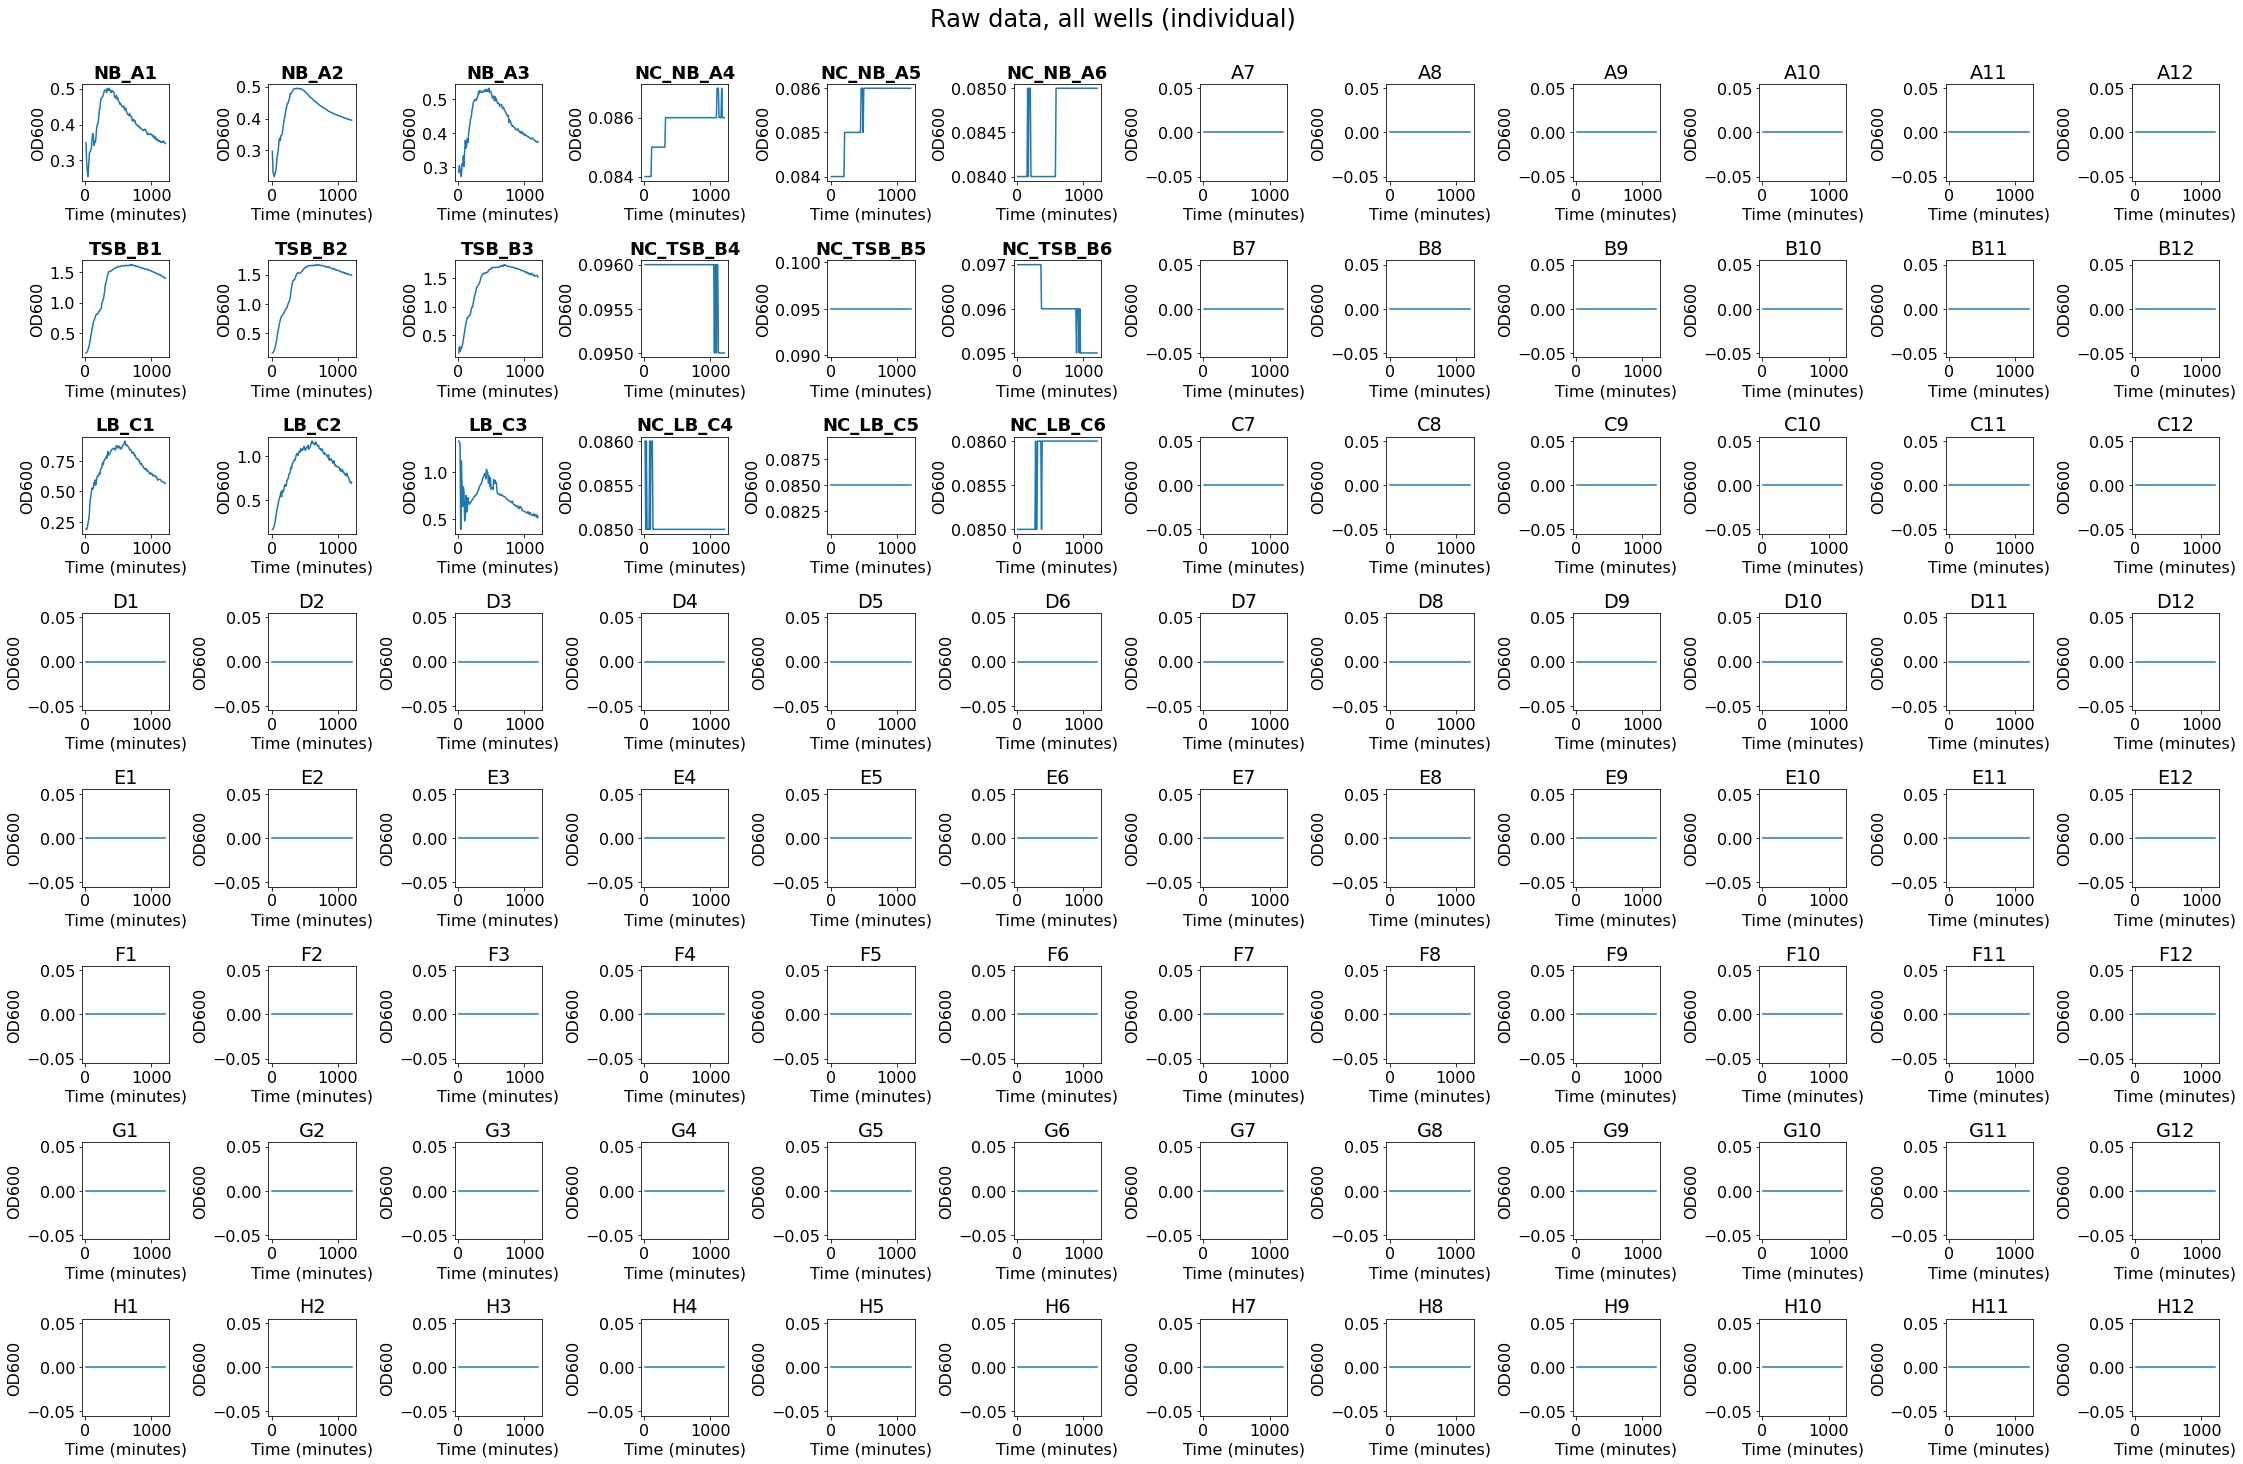

<Figure size 432x288 with 0 Axes>

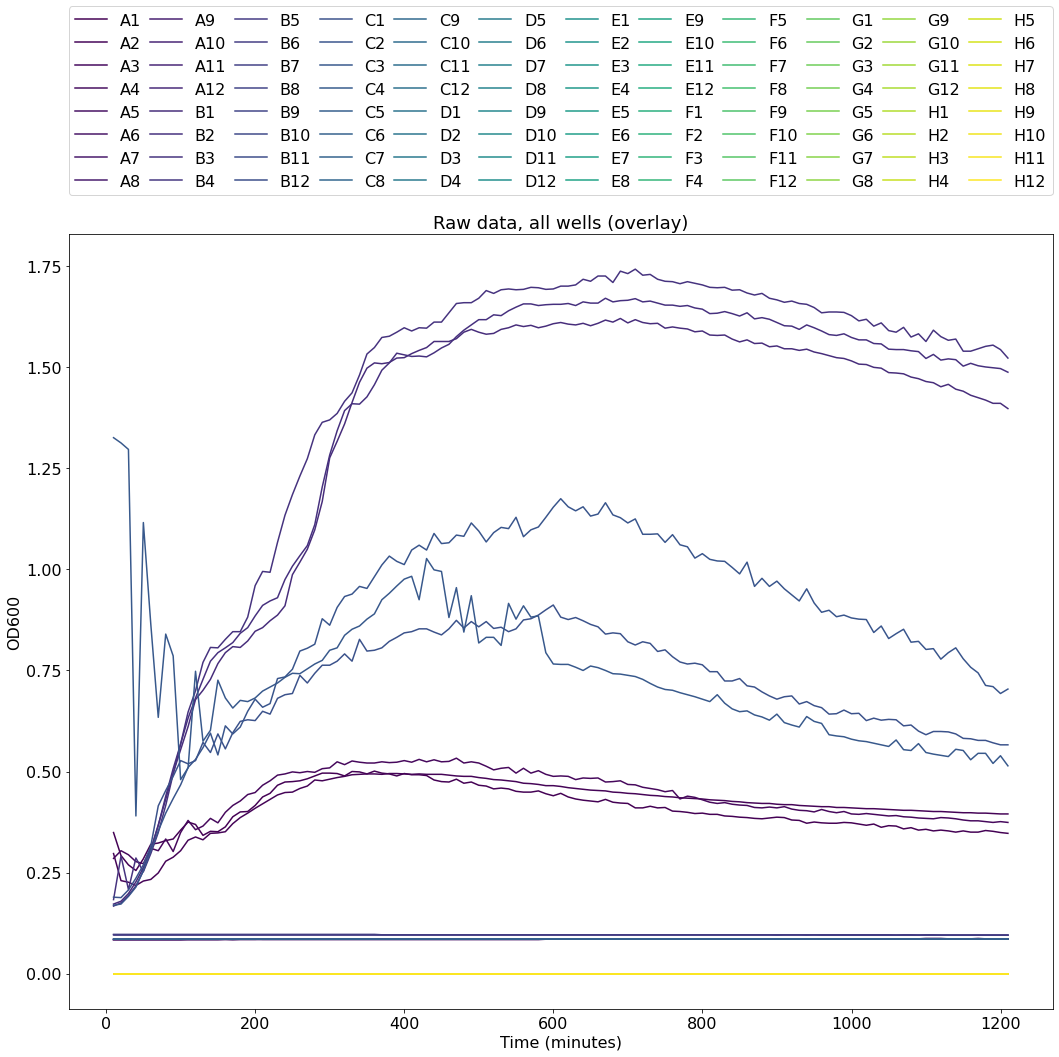

37.01, 37.1, 36.9
9 of 96 wells
0 of 9 blank wells


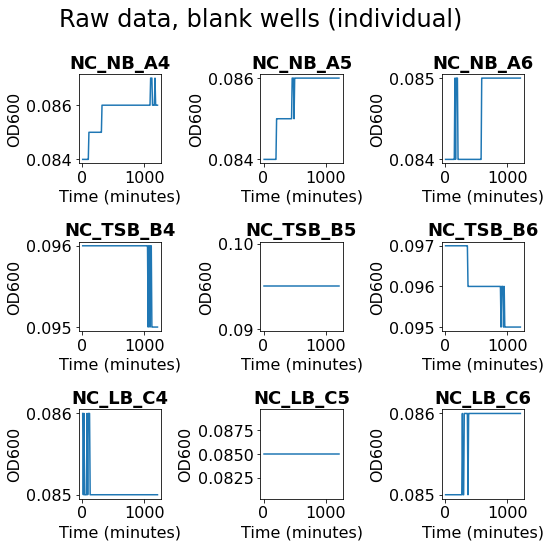

<Figure size 432x288 with 0 Axes>

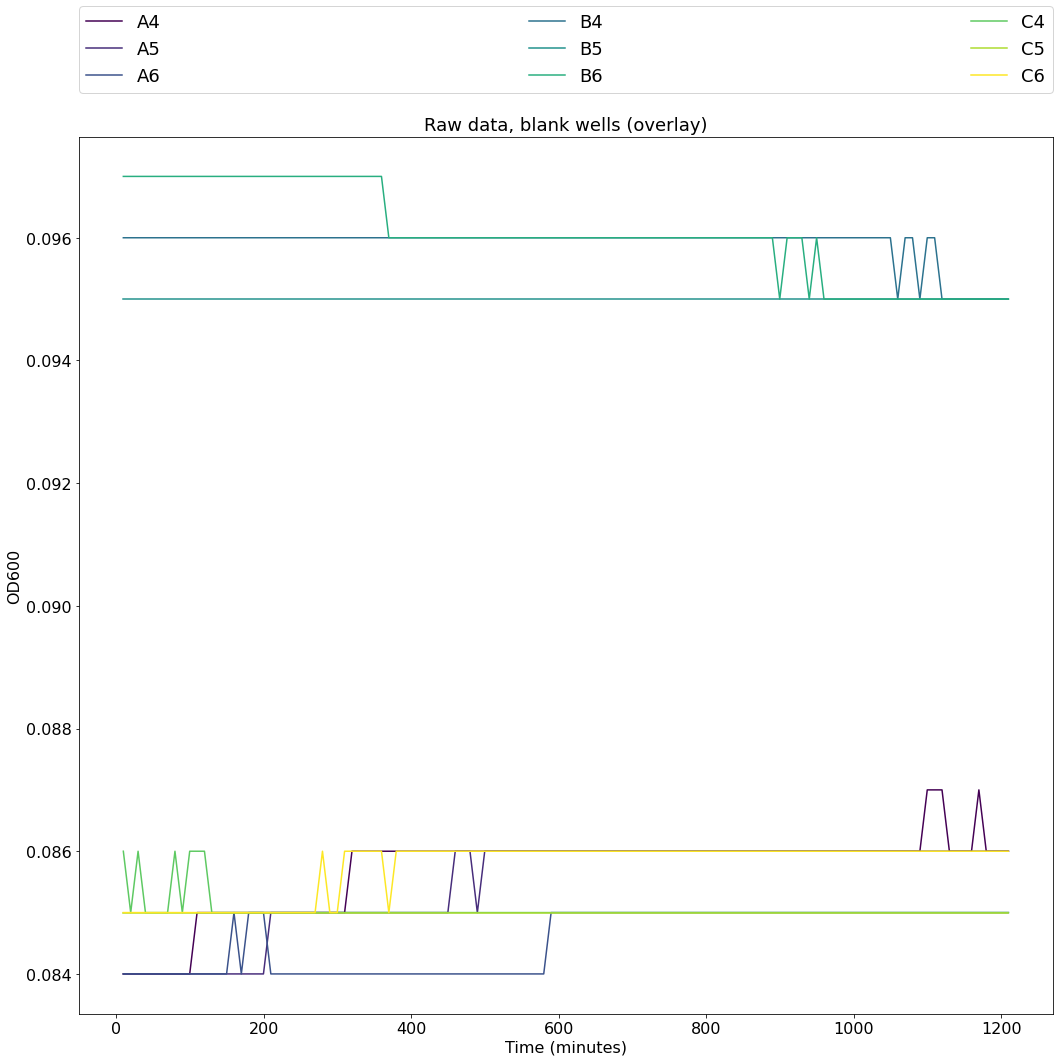

In [21]:
# general plots

# plot all the wells in subplots to look like the plate
def plotPlate(plate, title, figname,y_label):
    
    # plots multiple subplots of  a given dataframe
    i=0
    # use plate columns to get the number of columns and rows for the subplots
    nrows=set()
    ncols=set()
    for col in plate.columns:
        if any(x in col for x in['Time','T° 600','total_minutes']):
            continue  
        w=re.match("([A-Z])([0-9]+)",col)
        nrows.add(w.group(1))
        ncols.add(w.group(2))
    fig=plt.figure(figsize=(2.6*len(ncols),2.6*len(nrows)))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    # Add the main title
    fig.suptitle(title, fontsize=24)
    for col in plate.columns:
        # skip the time and temperature column
        if any(x in col for x in['Time','T° 600','total_minutes']):
            continue    
        # go down a row every 12 wells
        i+=1
        '''if i%12==0:
            i=1'''
        ax=fig.add_subplot(len(nrows),len(ncols),i)
        ax.plot(plate['total_minutes'], plate[col])
        if col in col2sample:
            plt.title(col2sample[col]+'_'+col,fontweight="bold", fontsize=18)
        else:
            plt.title(col)
        plt.xlabel('Time (minutes)')
        plt.ylabel(y_label)
    plt.tight_layout()
    plt.savefig(figname +'.svg')
    
    plt.savefig(figname, dpi=150)
    plt.show()
    

fig1A_name=graphicspath+'/Figure1A_'+filename+'.png'
# Figure 1A: Raw data, all wells (individual)
plotPlate(expdf,'Raw data, all wells (individual)\n',fig1A_name,'OD600') 

# Figure 1B: Raw data, all wells (overlay)
# use a sequential color map that will not have duplicate shades
pltdf=expdf.drop(columns=['T° 600','Time'])
plt.figure()
pltdf.plot(x='total_minutes',
          cmap='viridis',
          figsize=(15,15),
          fontsize=16)
plt.xlabel('Time (minutes)', fontsize=16)
plt.ylabel('OD600', fontsize=16)
plt.title('Raw data, all wells (overlay)', fontsize=18)
# style the legend
plt.legend(bbox_to_anchor=(0,1.05,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=12)
plt.tight_layout()
plt.savefig(graphicspath+'/Figure1B_'+filename +'.svg')
fig1B_name=graphicspath+'/Figure1B_'+filename +'.png'
plt.savefig(fig1B_name, dpi=150)
plt.show()
# temperature distribution across time
cnames=expdf.columns

# get the temparature average, maximum and minimum
Temp_mean=expdf['T° 600'].mean()
Temp_max=expdf['T° 600'].max()
Temp_min=expdf['T° 600'].min()
Temp_str="{:.2f}".format(Temp_mean)+', '+str(Temp_max)+', '+str(Temp_min)
print(Temp_str)
'''expdf.plot(x=cnames[0], y=cnames[1], figsize=(10,5), color='grey',style=".")
plt.title('Temperature change with time')
plt.ylabel('Temperature, Celsius')
plt.savefig(graphicspath+'/tempvstime_'+filename+'.svg')
plt.show()

plt.figure()
expdf[cnames[1]].plot.kde(figsize=(10,5), title='Temperature distribution in the experiment')
plt.xlabel('Temperature, Celsius')
plt.savefig(graphicspath+'/temp_dist_'+filename+'.svg')
plt.show()'''

# check for growth or no growth in all wells
detected_growth=set()
blanks_det_gr=set()
blankcols=set()
for wcol in expdf.columns:
     # skip the time and temperature column
    if any(x in wcol for x in['Time','T° 600','total_minutes']):
        continue  
    gdf=expdf[expdf[wcol]>=0.2]
    if len(gdf.index)>1:
        if wcol in col2blanks:
            
            blanks_det_gr.add(wcol)
        detected_growth.add(wcol)

det_gr_str=str(len(detected_growth))+' of 96 wells'
print(det_gr_str)
if len(blanks_det_gr)>1:
    det_gr_blanks_str=str(len(blanks_det_gr))+' of '+ str(len(col2blanks))+' blank wells (well '+','.join(sorted(list(blanks_det_gr)))
else:
    det_gr_blanks_str=str(len(blanks_det_gr))+' of '+ str(len(col2blanks))+' blank wells'
print(det_gr_blanks_str)


# Figure 2A - Raw data, blank wells (individual) 
fig2A_name=graphicspath+'/Figure2A_'+filename+'.png'
# plot the figure
for b in blanks:
    for bcol in blanks[b]:
        blankcols.add(bcol)
fig2a_cols=sorted(list(blankcols))
fig2a_cols.append('total_minutes')        
plotPlate(expdf[fig2a_cols],'Raw data, blank wells (individual)',fig2A_name,'OD600')


# Figure 2B - Raw data, blank wells (overlay) 
pltdf=expdf[fig2a_cols]
plt.figure()
pltdf.plot(x='total_minutes',
          cmap='viridis',
          figsize=(15,15),
          fontsize=16)
plt.xlabel('Time (minutes)', fontsize=16)
plt.ylabel('OD600', fontsize=16)
plt.title('Raw data, blank wells (overlay)', fontsize=18)
# style the legend
plt.legend(bbox_to_anchor=(0,1.05,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, fontsize=18)
plt.tight_layout()
plt.savefig(graphicspath+'/Figure2B_'+filename +'.svg')
fig2B_name=graphicspath+'/Figure2B_'+filename +'.png'
plt.savefig(fig2B_name, dpi=150)
plt.show()




# Blank subtraction
After reading the plate, identify samples by loading a sample file

121it [00:00, 3457.11it/s]


<Figure size 432x288 with 0 Axes>

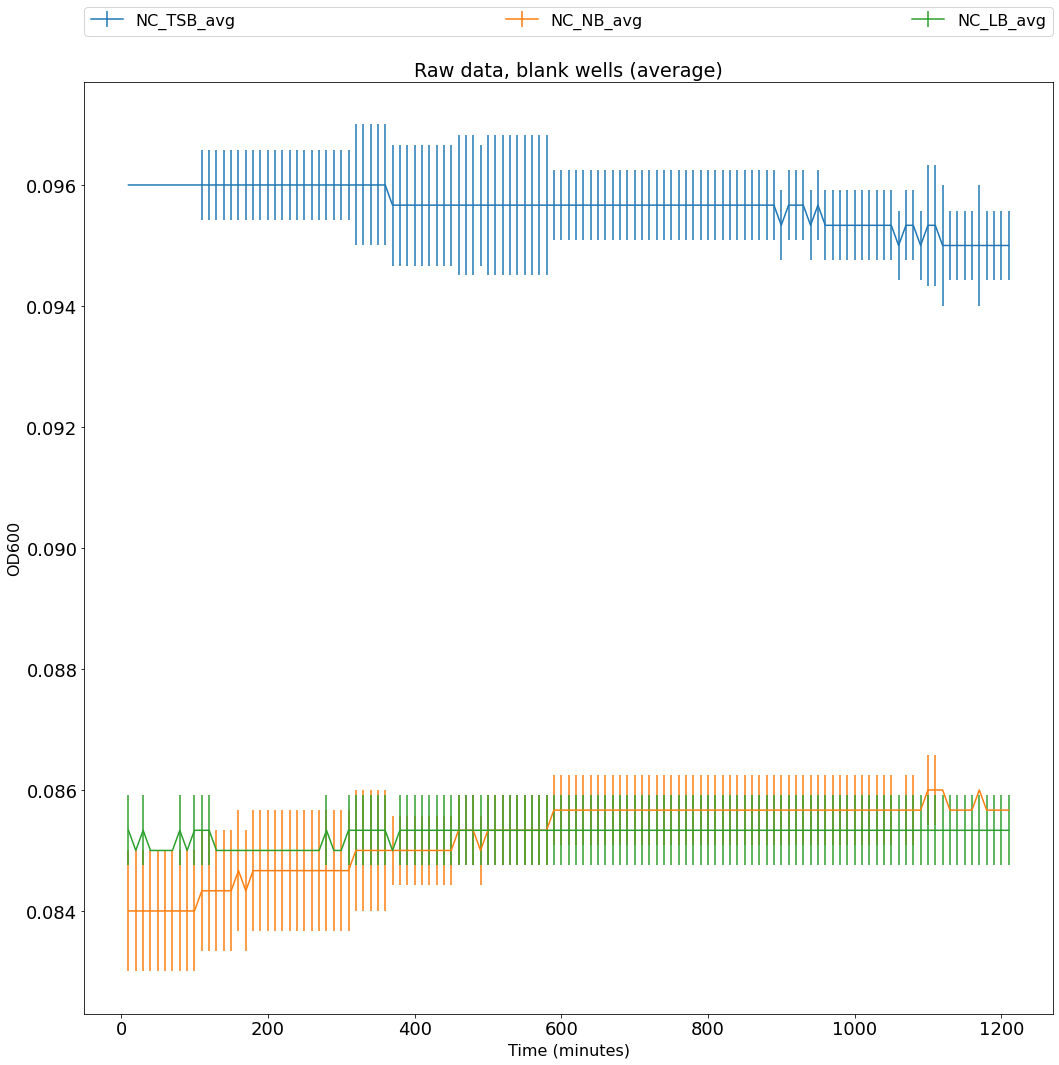

In [22]:
# subtract blanks
# this will have the output table
workdf = pd.DataFrame()
cleandf=pd.DataFrame()
wd={}
cdict={}
nc_err_names=[]
nc_avg_names=set()
ncdict = {}
blank2samples={}
# ---------------analyze plate---------------------------

# plot all the wells in both semilog (y) and regular plots

for i, tp in tqdm(expdf.iterrows()):
    ncdict[tp['total_minutes']] = {}
    wd[tp['total_minutes']]={}
    cdict[tp['total_minutes']]={}
    # calculate the average  and standard deviation per sample
    
    # blanks
    for b in blanks:
        curcols=[]
        vals=[]
        for nc in blanks[b]:
            vals.append(tp[nc])
        nc_avg=statistics.mean(vals)
        nc_stdev=statistics.stdev(vals)
        nca_name = b+'_avg'
        ncs_name = b+'_stdev'
        ncdict[tp['total_minutes']][nca_name] = nc_avg
        ncdict[tp['total_minutes']][ncs_name] = nc_stdev
        nc_err_names.append(ncs_name)
        nc_avg_names.add(nca_name)
        
        # find the columns matching the blank, the blanks are named NC_sample
        bsample=b.split('_')
        cursample=bsample[1].strip()
        # get the column list for the matching sample
        curcols=samples[cursample]
        blank2samples[b]=curcols
        
        # create a clean version for column selecting
        for ccol in curcols:
            #ccol_name = ccol+'_mb'
            cdict[tp['total_minutes']][ccol] =tp[ccol]-nc_avg
        # add the blank columns
        curcols=curcols+blanks[b]
        
        
        
        # subtract the blank average from each column value and keep in a new table
        
        for ccol in curcols:
            
            
            #ccol_name = ccol+'_mb'
            wd[tp['total_minutes']][ccol] =tp[ccol]-nc_avg

ncdf = pd.DataFrame.from_dict(ncdict, orient='index')
ncdf.index=ncdf.index.set_names(['total_minutes'])
ncdf.reset_index(inplace=True)

# get the new plate after subtracting the blanks - blank wells should show  around zero values
workdf = pd.DataFrame.from_dict(wd, orient='index')
workdf.index=workdf.index.set_names(['total_minutes'])
workdf.reset_index(inplace=True)

cleandf = pd.DataFrame.from_dict(cdict, orient='index')
cleandf.index=cleandf.index.set_names(['total_minutes'])
cleandf.reset_index(inplace=True)
# plot the blanks for a closer look


plt.figure()
plt.rcParams.update({'font.size': 16}) 
ncdf.plot(x='total_minutes',  y=list(nc_avg_names),yerr=ncdf[nc_err_names].T.values,
             figsize=(15,15),
             ylabel='OD600',
             xlabel='Time (minutes)',
             title='Raw data, blank wells (average)',
             #logy=True,
             fontsize=18,
             #color=colors
             )
plt.legend(bbox_to_anchor=(0,1.05,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
plt.tight_layout()
plt.savefig(graphicspath+'/blanks'+filename+'.svg')
plt.savefig(graphicspath+'/Figure2C_'+filename +'.svg')
fig2C_name=graphicspath+'/Figure2C_'+filename +'.png'
plt.savefig(fig2C_name, dpi=150)
plt.show()





#workdf


# Add log2 values 

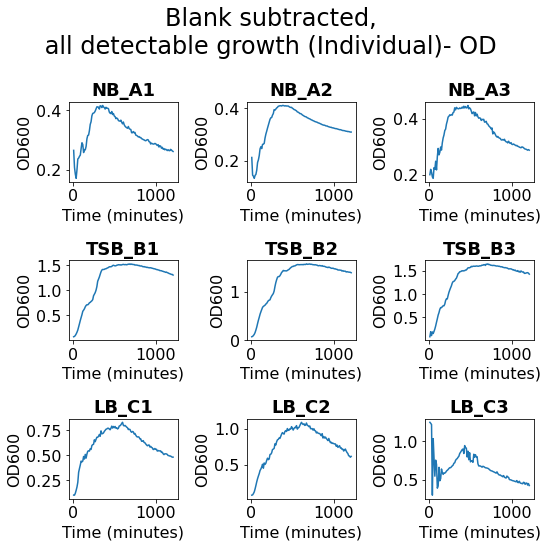

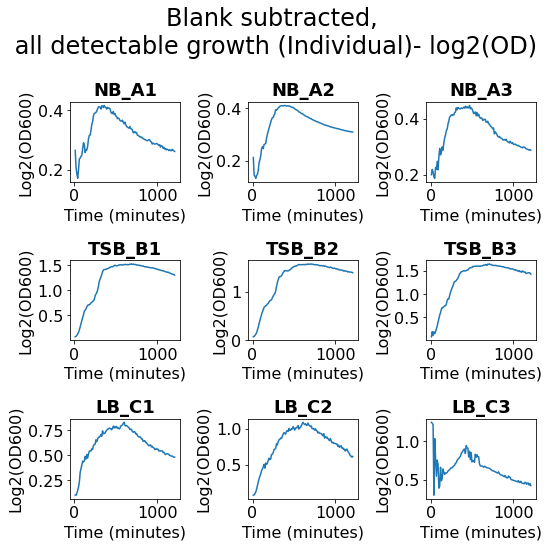

<Figure size 432x288 with 0 Axes>

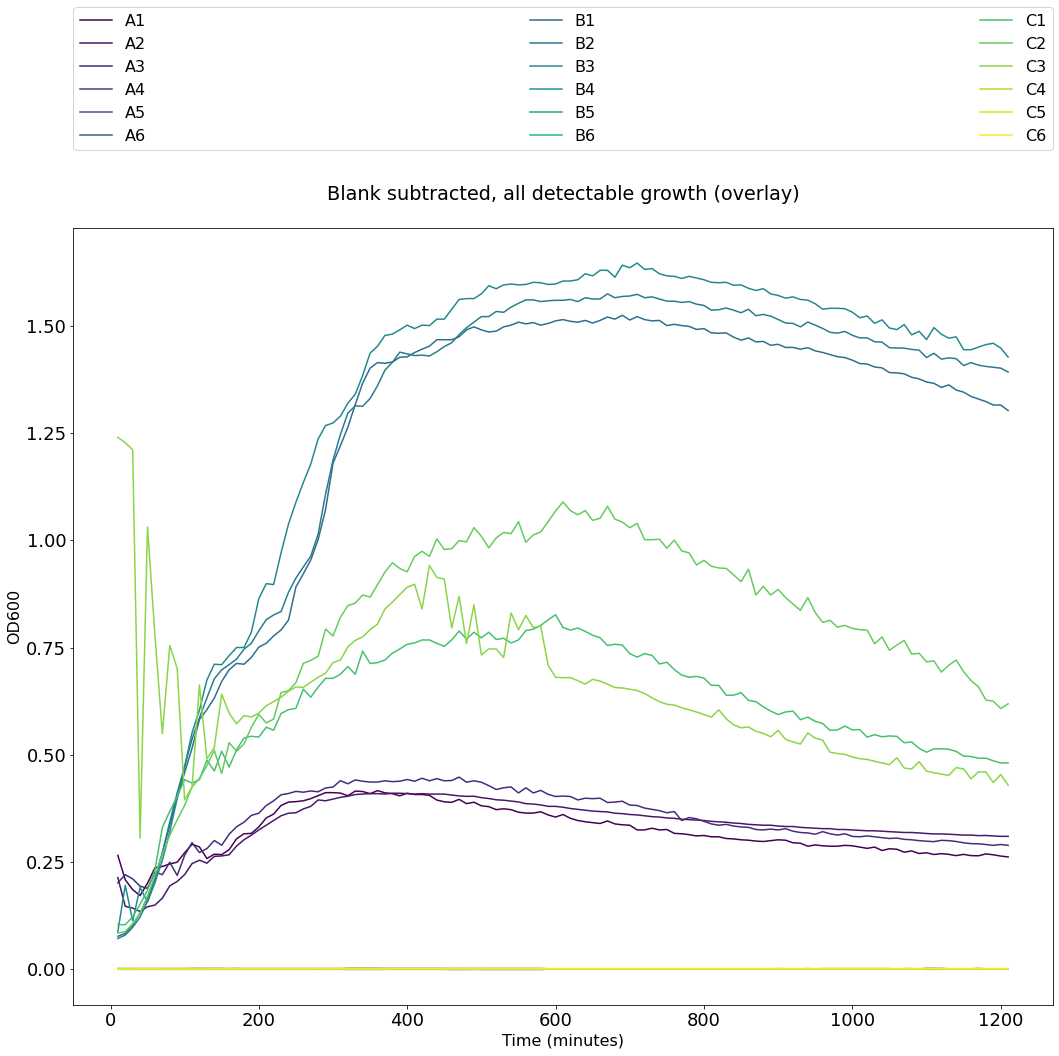

In [23]:
# add log2 values, this time no need to work with the blank columns
nsamples={}
log2tdf=pd.DataFrame()
log2tdf=pd.concat([log2tdf,workdf['total_minutes']],axis=1)
regcols=set()
log2cols=set()
for sample in list(samples):
    if 'NC' in sample or sample in nsamples:
        continue
    # add the new sample name to the samples dictionary for easy plotting
    nsample_name=sample+'_log2'
    nsamples[nsample_name]=set()
    for well in samples[sample]:
        nwell_name=well+'00'
        regcols.add(well)
        log2cols.add(nwell_name)
        nsamples[nsample_name].add(nwell_name)
        wclog2=np.log2(workdf[well].values)
        col2sample[nwell_name]=nsample_name
        # add to the table
        wclog2series=pd.Series(wclog2,name=nwell_name)
        log2tdf=pd.concat([log2tdf,wclog2series],axis=1)
        log2tdf=pd.concat([log2tdf,workdf[well]],axis=1)
# update the samples dictionary
samples.update(nsamples)

'''print('Growth/no growth report:')
# add the growth/no growth table view. Growth is anything above OD 0.2 - display format: sample name: well: growth/no growth
for sam in samples:
    if 'log2' in sam:
        continue
    print(sam+':')
    for lcol in samples[sam]:
        
        # look atg the od values after blank subtraction
        if '00' in lcol or 'total_minutes' in lcol:
            continue
        
        gdf=log2tdf[log2tdf[lcol]>=0.2]
        if len(gdf.index)>1:
            print(lcol+': Growth')
        else:
            print(lcol+': No growth')'''
        
        
#plot the new 'plate' for figure 3A - need to do two sections - one for OD and one for the log2 values
# OD plot
fig3A_name=graphicspath+'/Figure3A_'+filename +'.png'
regcols=sorted(list(regcols))
regcols.append('total_minutes')
plotPlate(log2tdf[regcols],'Blank subtracted,\n all detectable growth (Individual)- OD ',fig3A_name,'OD600')  

# log2 plot
log2cols=sorted(list(log2cols))
log2cols=[x.replace('00','') for x in log2cols]
log2cols.append('total_minutes')
fig3Aii_name=graphicspath+'/test1'+filename +'.png'
plotPlate(log2tdf[log2cols],'Blank subtracted,\n all detectable growth (Individual)- log2(OD)',fig3Aii_name,'Log2(OD600)')  



'''# save the dataframe to a file with the sample titles
sample_names_io=['total_minutes']
for col in log2tdf.columns:
    if 'total_minutes' in col:
        continue
    sample_names_io.append(col2sample[col])
outdf=log2tdf
# change column names in output table
outdf.columns=sample_names_io
outdf.to_csv(respath+'/'+'sample_data_wlog2_'+filename+'.csv')
outdf'''

log2tdf.to_excel(respath+'/samples_wlog2_vals_'+filename+'.xlsx')
log2tdf.to_csv(respath+'/samples_wlog2_vals_'+filename+'.csv')

#Figure 3B: Blank subtracted, all detectable growth (overlay) 
plt.figure()
plt.rcParams.update({'font.size': 16}) 
workdf.plot(x='total_minutes',
             figsize=(15,15),
             ylabel='OD600',
             xlabel='Time (minutes)',
             title='Blank subtracted, all detectable growth (overlay)\n ',
             #logy=True,
             fontsize=18,
             cmap='viridis'
             )
plt.legend(bbox_to_anchor=(0,1.1,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
plt.tight_layout()
plt.savefig(graphicspath+'/Figure3B_'+filename +'.svg')
fig3B_name=graphicspath+'/Figure3B_'+filename +'.png'
plt.savefig(fig3B_name, dpi=150)
plt.show()


# Get metrics for all the sample wells curves

In [24]:
# calculate maxOD and time to reach maxOD for the wells in log2tdf
# the final table will look like 
# well | maxOD | ttr_maxOD | mid_log OD | ttr_mid_logOD | growth_rate | doubeling_time

# using a max slope approach to catch the growth rate. The window for slope calculations will be 3 points.
# the time to reach max slope will be for the end point of the window.
# All slope calculations will be done on the log2 values.

def getMetrics(col,ogdf):
    # returns the mid-log OD and time to reach mid log
    # uses rolling regression and R values to capture different segments of the curve
    
    # rolling regression - get the R values for a regression line in every coordinate
    # curve is a list of curve values over time - log2
    # to get the od values we use the log2tdf dataframe
    ogcol=col.replace('00','')
    # add an OD filter - get rid of anything lower than 0.1
    tdf_1=ogdf[ogdf[ogcol]>0.1]
    curve1=tdf_1['total_minutes']
    curve2=tdf_1[col]
    
    #time
    curve1_list=tdf_1['total_minutes'].values.tolist()
    # log2 values
    curve2_list=tdf_1[col].values.tolist()
    window=2
    slopes = []
    intercepts = []
    Rs=[]
    windows={}
    idlist=tdf_1.index.values.tolist()
    # get the values for the window
    for c in range(len(idlist)-window):
        #adjust c to the filtered index
        ca=idlist[c]
        ogx=curve1.loc[ca:ca+window]
        ogy=curve2.loc[ca:ca+window]
        y=np.array(ogy.values.tolist())
        x=np.array(ogx.values.tolist())
        y=y.reshape(-1,1)
        x=x.reshape(-1,1)
        lr=LinearRegression()
        lr.fit(x,y)
        R_coef=lr.score(x,y)
        '''if R_coef<0.95:
            #print(col+'\t'+str(c)+' minutes')
            #print(R_coef)
            exp=c
            break'''
            
        Rs.append(R_coef)
        intercepts.append(lr.intercept_)
        slopes.append(float(lr.coef_[0]))
        # store the window indices information in a dictionary the keys will be window numbers which will correlate with slope numbers.
        # every window gets one slope and one R coefficient number
        windows[c]=c+window
        
    
    # find the index for the window that has the maximum slope
    # max_slope
    max_slope=max(slopes)
    max_slope_idx=slopes.index(max_slope)
    # get the values for the max_slope and time to max_slope
    
    
    # get the place on the general curve for fetching the time to max sloe
    max_slope_indx=windows[max_slope_idx]
    ogmax_slope_val=curve2_list[max_slope_indx]
    # inverse log 2 back to od
    max_slope_val=2**ogmax_slope_val

    ttr_max_slope=curve1_list[max_slope_indx]
          
    # get the metrics
    max_slope_R=Rs[max_slope_idx]
    
    dbl_time=1/max_slope
    
    '''# plot the curve for eyballing - now add the max_slope point
    plt.figure(figsize=(8,8))
    sns.lineplot(x=curve1_list, y=curve2_list)
    plt.axhline(y=ogmax_slope_val, color='grey', linestyle='--')
    plt.axvline(x=ttr_max_slope, color='black', linestyle='--')
    plt.title(col)
    plt.show()'''
    
    
    
    return max_slope,max_slope_val, dbl_time,ttr_max_slope, max_slope_R



fpopdf=pd.DataFrame()
for col in log2tdf.columns:
    if not '00' in col or 'total_minutes' in col:
        continue
    # get the values for the maxOD, midlog, growth rate and doubling time
    max_slope,max_slope_od,dbt,ttr_max_slope,max_slop_R=getMetrics(col,log2tdf)
    # use the indices to get the values from the series
    # for max OD I need to use the original columns
    ogcol=col.replace('00','')
    ogcol_list=list(log2tdf[ogcol].values)
    max_od=max(log2tdf[ogcol].values)
    # get the values for ttr_maxOD,and ttr to midlog
    ttr_max_idx=log2tdf.index[log2tdf[ogcol]==max_od].values
    ttr_max_idx=ttr_max_idx[0]
    ttr_max_od=log2tdf.loc[ttr_max_idx]['total_minutes']
    
    # update the table
    values_to_add = {'Well': ogcol,'Sample name':col2sample[ogcol],'Doubling time (minutes)':dbt,'max_OD (OD600)':max_od,
                     'Max_Slope':max_slope,'Time_to_maxOD (minutes)':ttr_max_od,
                     'Max_SlopeOD':max_slope_od,'Time_to_Max_Slope (minutes)':ttr_max_slope }
    row_to_add = pd.Series(values_to_add, name=ogcol)
    new_df=pd.DataFrame([row_to_add], columns=row_to_add._stat_axis)
    fpopdf = pd.concat([fpopdf,new_df],ignore_index=True)
    

# Table1 - Calculated growth parameters (individual wells)
table1_name=graphicspath+'/Table1_'+filename +'.png'
table1=dfi.export(fpopdf, table1_name)   
fpopdf  

Well Sample name  Doubling time (minutes)  max_OD (OD600)  Max_Slope  \
0   A1          NB                43.030136        0.416000   0.023240   
1   A2          NB                52.528689        0.410000   0.019037   
2   A3          NB                46.002844        0.447667   0.021738   
3   B1         TSB                28.073193        1.525333   0.035621   
4   B2         TSB                24.930321        1.575333   0.040112   
5   B3         TSB                28.670080        1.647333   0.034880   
6   C1          LB                23.731541        0.826667   0.042138   
7   C2          LB                26.421578        1.089667   0.037848   
8   C3          LB                14.783997        1.240667   0.067641   

   Time_to_maxOD (minutes)  Max_SlopeOD  Time_to_Max_Slope (minutes)  
0               359.833333     0.236000                    59.833333  
1               379.833333     0.194000                    79.833333  
2               469.833333     0.294667                   109.833333  
3               689.833333     0.272000                    69.833333  
4               669.833333     0.211000                    59.833333  
5               709.833333     0.253000                    69.833333  
6               599.833333     0.330000                    69.833333  
7               609.833333     0.218000                    59.833333  
8                 9.833333     0.779000                    59.833333

# Plot the plate in a per metric look for column selection

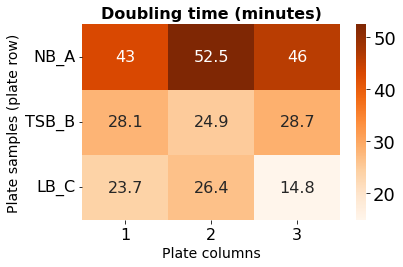

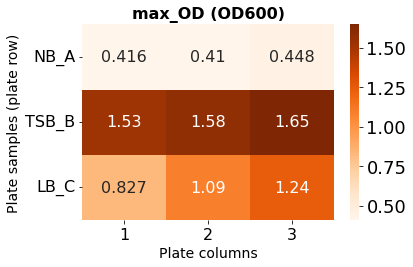

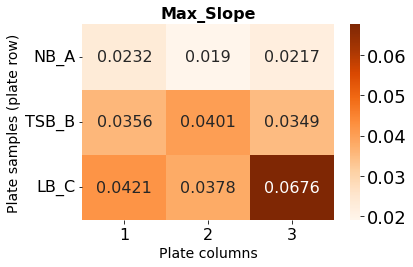

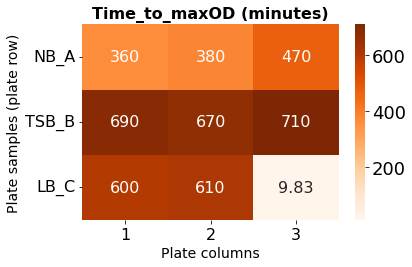

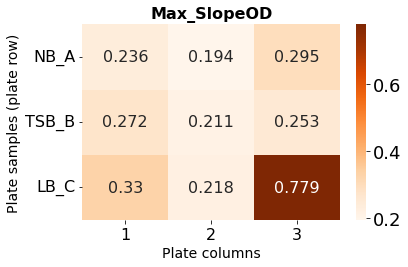

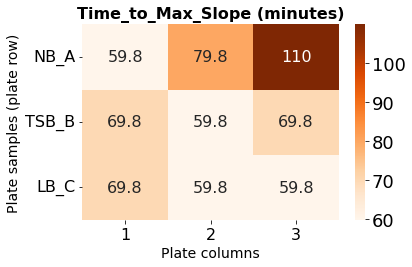

In [25]:
# plot a single metric look of the samples
def plotPlateSM(plate,metric, figname):
    
    # plot a heatmap of the sample/well vs a metric
    # use plate columns to get the number of columns and rows for the subplots
    nrows=set()
    ncols=set()
    
    tempdict={}
    tempdf=pd.DataFrame()
    vals=[]
    letters=[]
    numbers=set()
    
    for col in plate['Well']:  
        w=re.match("([A-Z])([0-9]+)",col)
        letter=w.group(1)
        nrows.add(letter)
        num=w.group(2)
        numbers.add(num)
        met_idx=plate.index[plate['Well']==col].values
        met_idx=met_idx[0]
        val=plate.loc[met_idx][metric]
        # change letter titles to sample names
        sname=col2sample[col]+'_'+letter
        if sname not in tempdict:
            tempdict[sname]=[]
        tempdict[sname].append(val)
        
    numbers=list(sorted(numbers))    
    # build the df por plotting
    tempdf=pd.DataFrame.from_dict(tempdict, orient='index',columns=numbers)
    # plot
    #sns.set(rc = {'figure.figsize':(0.5*len(nrows),0.5*len(ncols))})
    ax=sns.heatmap(tempdf, cmap='Oranges', annot=True,fmt='.3g')
    ax.tick_params(axis='y', rotation=0)
    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(metric, fontsize=16, fontweight="bold")
    plt.ylabel('Plate samples (plate row)', fontsize=14)
    plt.xlabel('Plate columns', fontsize=14)
    plt.tight_layout()
    plt.savefig(figname +'.svg')
    
    plt.savefig(figname, dpi=150)
    plt.show()
             
# Figure 4: Calculated growth parameters (individual wells) 

nrows=set()
numbers=set()
 
for col in fpopdf['Well']:  
    w=re.match("([A-Z])([0-9]+)",col)
    letter=w.group(1)
    nrows.add(letter)
    num=w.group(2)
    numbers.add(num)
plt.rcParams.update({'font.size': 16})
'''fig=plt.figure(figsize=(4*len(numbers),4*len(nrows)))
fig.subplots_adjust(hspace=0.4, wspace=0.4,)  '''

'''fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 30),
                       gridspec_kw={
                           'width_ratios': [3, 3],
                           'height_ratios': [3, 3,3],
                       'wspace': 0.4,
                       'hspace': 0.4})'''

# Add the main title
i=0
fig4={}
#fig.suptitle('Figure 4: Calculated growth parameters (individual wells)\n', fontsize=24)
for met in fpopdf.columns:
    # skip the metadata
    if any(x in met for x in ['Sample name','Well']):
        continue
    # plot in a 2x3 structure
    '''i+=1
    ax=fig.add_subplot(3,2,i)'''
    figname=graphicspath+'/Figure4_'+met+'_'+filename +'.png'
    fig4[met]=figname
    plotPlateSM(fpopdf,met,figname)

 

# Select columns to remove from the table
The code will drop two columns for each choice - one for the od values and one for the log2 values

In [26]:
# select columns to remove from a dataframe - using a clean version of the data without the log2
# creating a widget for viewing the dataframe

app = JupyterDash(__name__)
# Load Data
df = cleandf
# Build App
app.layout = html.Div([
            dash_table.DataTable(
                id='table',
                columns=[
                {"name": i, "id": i, "deletable": True, "selectable": True} for i in df.columns
                ],
                data=df.to_dict('records'),
                editable=True,
                filter_action="native",
                sort_action="native",
                sort_mode="multi",
                column_selectable="multi",
                row_selectable="multi",
                row_deletable=True,
                selected_columns=[],
                selected_rows=[],
                page_action="native",
                page_current= 0,
                page_size= 10,
            ),
            html.Div(id='datatable-interactivity-container'),
            html.Button(id="save-button",n_clicks=0,children="Save"),
            html.Div(id="output-1",children="Press button to save changes")
])

@app.callback(
        Output("output-1","children"),
        [Input("save-button","n_clicks")],
        [State("table","data")]
        )

def selected_data_to_csv(nclicks,table1): 
    if nclicks == 0:
        raise PreventUpdate
    else:
        pd.DataFrame(table1).to_csv(respath+'/interim_df.csv',index=False)
        return "Data processed, continue running notebook"

# Run app and display result inline in the notebook
app.run_server(mode='inline', debug=True)



# Continue analyzing with consolidated, cleaned data

Plotting the growth curves

In [30]:
# get the updated dataframe
graphdf=pd.read_csv(respath+'/interim_df.csv')

#remove the interim file
os.remove(respath+'/interim_df.csv')
sample2col={}
# update the parameter table after deletion of columns
# now the columns are stored in the well column in the parameter table
# get the updated column list
ucol_list=list(graphdf.columns)
for cc in list(fpopdf['Well']):
    if cc not in ucol_list:
        fpopdf.drop(fpopdf[fpopdf['Well']==cc].index,inplace=True)
        
# create an update sample2col mapping
for cc in list(fpopdf['Well']):
    dfline=fpopdf[fpopdf['Well']==cc]
    sample=dfline['Sample name'].values
    sample=sample[0]
    if sample not in sample2col:
        sample2col[sample]=set()
    sample2col[sample].add(cc)
    
fpopdf
        

Well Sample name  Doubling time (minutes)  max_OD (OD600)  Max_Slope  \
0   A1          NB                43.030136        0.416000   0.023240   
1   A2          NB                52.528689        0.410000   0.019037   
2   A3          NB                46.002844        0.447667   0.021738   
3   B1         TSB                28.073193        1.525333   0.035621   
4   B2         TSB                24.930321        1.575333   0.040112   
5   B3         TSB                28.670080        1.647333   0.034880   
6   C1          LB                23.731541        0.826667   0.042138   
7   C2          LB                26.421578        1.089667   0.037848   
8   C3          LB                14.783997        1.240667   0.067641   

   Time_to_maxOD (minutes)  Max_SlopeOD  Time_to_Max_Slope (minutes)  
0               359.833333     0.236000                    59.833333  
1               379.833333     0.194000                    79.833333  
2               469.833333     0.294667                   109.833333  
3               689.833333     0.272000                    69.833333  
4               669.833333     0.211000                    59.833333  
5               709.833333     0.253000                    69.833333  
6               599.833333     0.330000                    69.833333  
7               609.833333     0.218000                    59.833333  
8                 9.833333     0.779000                    59.833333

# Consolidate curve and parameter data
Calculate the average and standard deviation of sample using the wells that are left.

121it [00:00, 6049.93it/s]


<Figure size 432x288 with 0 Axes>

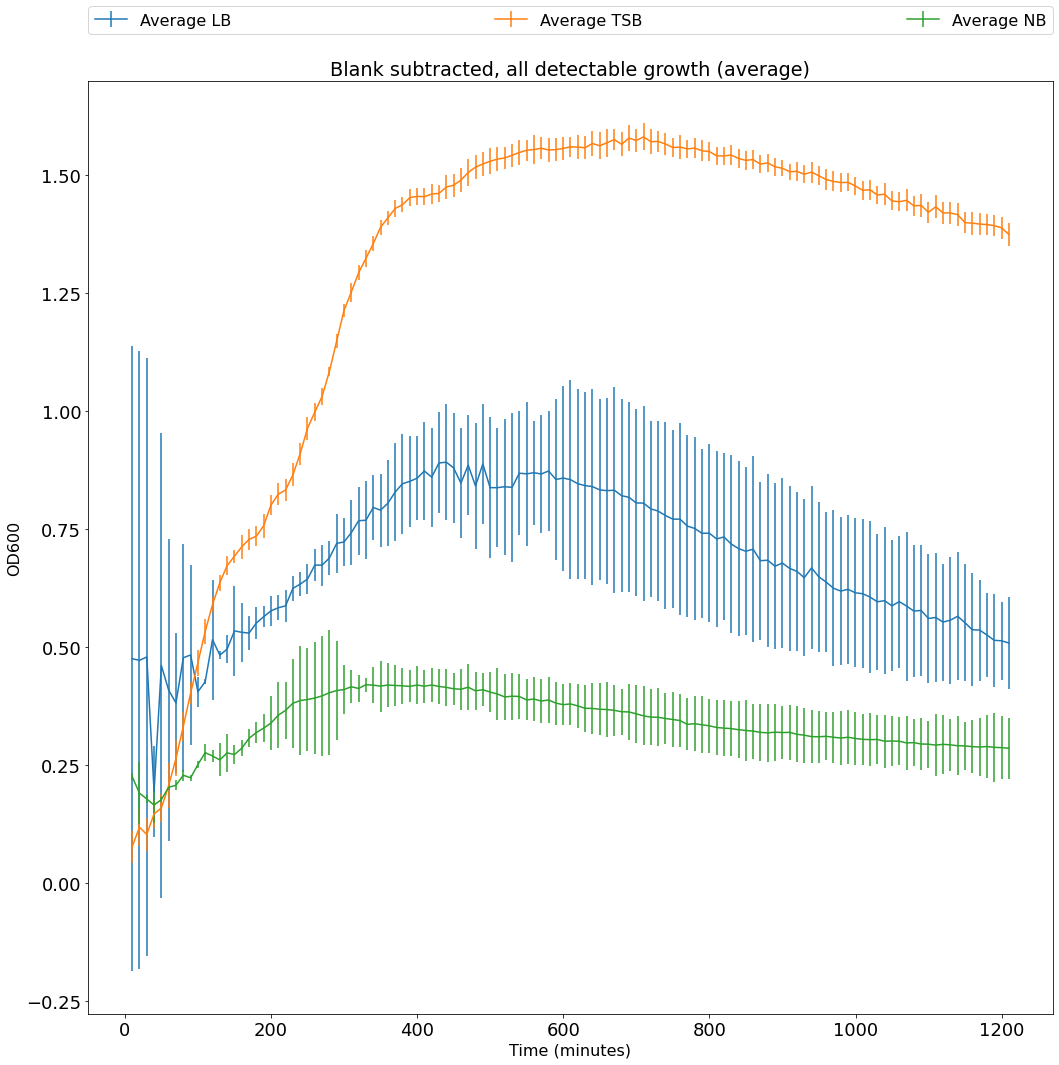

<Figure size 432x288 with 0 Axes>

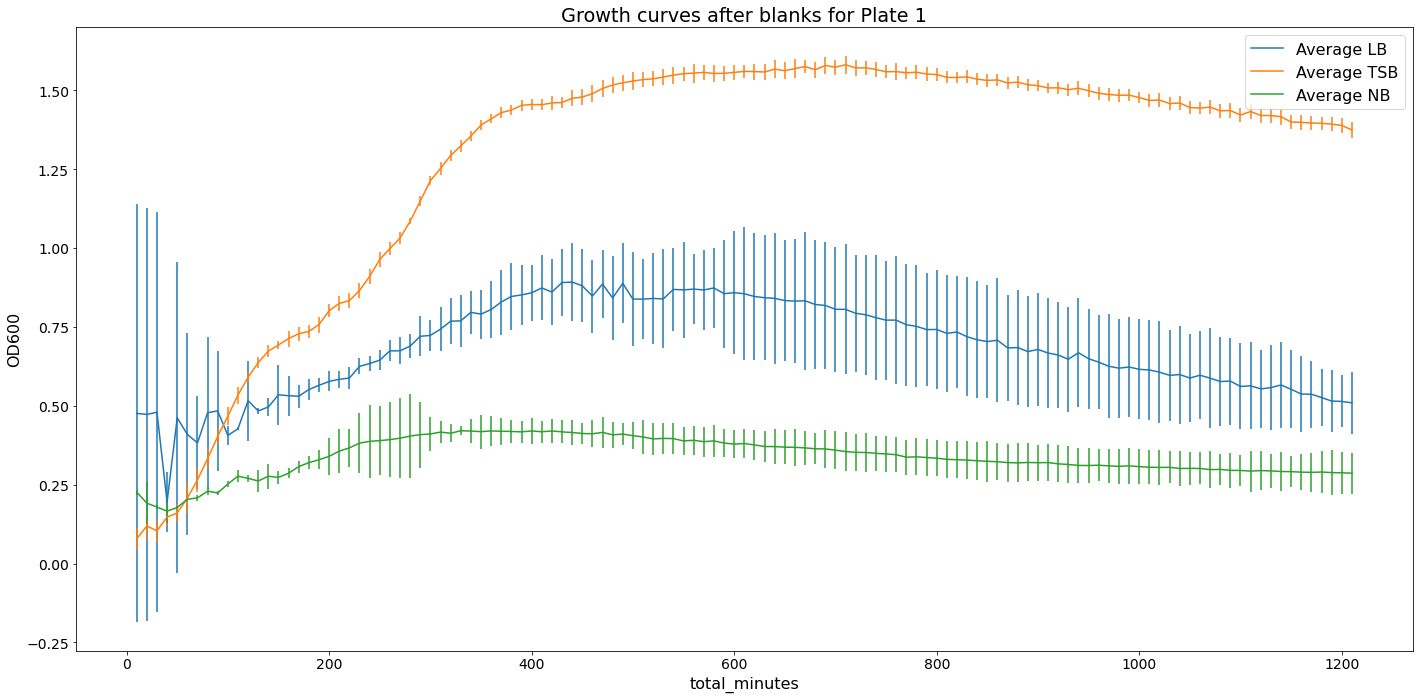

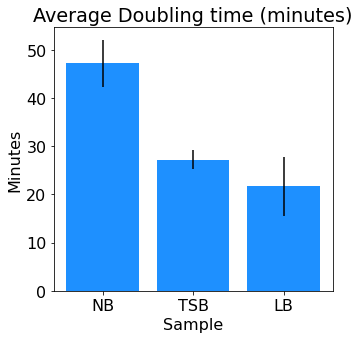

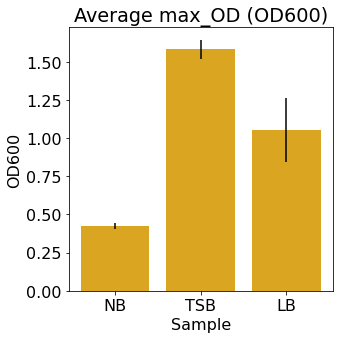

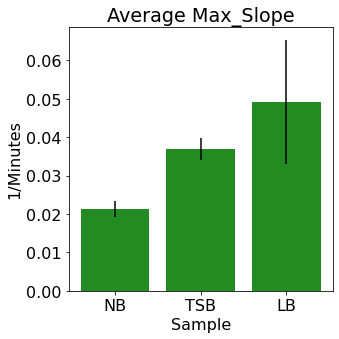

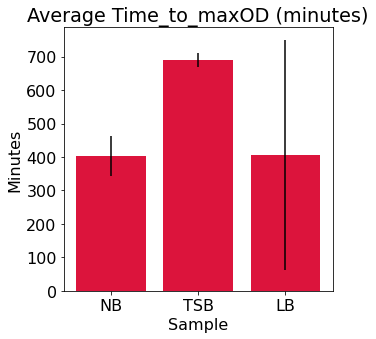

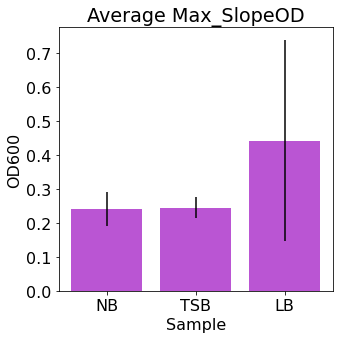

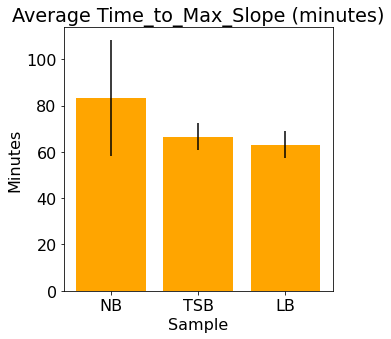

C:\Users\Shany Ofaim\AppData\Roaming\Python\Python310\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning:

this method is deprecated in favour of `Styler.to_html()`



In [31]:
# start with the curves

wd={}
s_err_names=set()
s_avg_names=set()
for i, tp in tqdm(graphdf.iterrows()):
    wd[tp['total_minutes']]={}
    # calculate the average  and standard deviation per sample
    
    # samples
    for s in sample2col:
        vals=[]
        for well in sample2col[s]:
            vals.append(tp[well])
        s_avg=statistics.mean(vals)
        if len(sample2col[s])<2:
            s_stdev=0
        else:
            s_stdev=statistics.stdev(vals)
        ns_name = 'Average '+s
        nst_name = 'stdev '+ s
        wd[tp['total_minutes']][ns_name] = s_avg
        wd[tp['total_minutes']][nst_name] = s_stdev
        s_err_names.add(nst_name)
        s_avg_names.add(ns_name)
stl=list(s_err_names)
sl=list(s_avg_names)
ngraphdf = pd.DataFrame.from_dict(wd, orient='index')
ngraphdf.index=ngraphdf.index.set_names(['total_minutes'])
ngraphdf.reset_index(inplace=True)

# Table2 - Calculated growth parameters (averages)
table2=dfi.export(fpopdf, 'Table2.png')  

#Figure 3C:Blank subtracted, all detectable growth (average)
plt.figure() 
ngraphdf.plot(x='total_minutes', y=sl,yerr=ngraphdf[stl].T.values, 
             figsize=(15,15),
             ylabel='OD600',
             xlabel='Time (minutes)',
             title='Blank subtracted, all detectable growth (average)',
             fontsize=18,
             )
plt.legend(bbox_to_anchor=(0,1.05,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
plt.tight_layout()
plt.savefig(graphicspath+'/Figure3C_'+filename +'.svg')
fig3C_name=graphicspath+'/Figure3C_'+filename +'.png'
plt.savefig(fig3C_name, dpi=150)
plt.show() 

# plot regular axis
#plot
plt.figure()
plt.rcParams.update({'font.size': 16}) 
ngraphdf.plot(x='total_minutes', y=sl,yerr=ngraphdf[stl].T.values, 
             figsize=(20,10),
             ylabel='OD600',
             title='Growth curves after blanks for '+plateid,
             #logy=True,
             fontsize=14,
             )

plt.tight_layout()
plt.savefig(graphicspath+'/growth_curves_regaxis_'+filename+'.svg')
plt.show() 

# now do the parameters

wpd={}
errdict={}

for col in fpopdf.columns:
    
    if any(x in col for x in ['Sample name', 'Well']):
        continue
    # now we have the parameters columns and we can go over the samples and get the values
    # calculate the average  and standard deviation per sample
    
    # samples
    for s in sample2col:
        if s not in wpd:
            wpd[s]={}
        vals=[]
        for well in sample2col[s]:
            # get the index of the well
            idx=fpopdf.index[fpopdf['Well']==well].values
            idx=idx[0]
            val=fpopdf.loc[idx][col]
            vals.append(val)
        s_avg=statistics.mean(vals)
        if len(sample2col[s])<2:
            s_stdev=0
        else:
            s_stdev=statistics.stdev(vals)
        ns_name = 'Average '+col
        nst_name = 'stdev '+col
        wpd[s][ns_name] = s_avg
        wpd[s][nst_name] = s_stdev
        errdict[ns_name]=nst_name

npdf = pd.DataFrame.from_dict(wpd, orient='index')
npdf.index=npdf.index.set_names(['sample'])
npdf.reset_index(inplace=True)
mcolors=['dodgerblue','goldenrod','forestgreen','crimson','mediumorchid','orange','deepskyblue','orangered','navy','lightseagreen','deeppink']

lbdict={'Average max_OD (OD600)': 'OD600',
        'Average Max_Slope':'1/Minutes',
        'Average Doubling time (minutes)':'Minutes',
        'Average Time_to_maxOD (minutes)':'Minutes',
        'Average Max_SlopeOD':'OD600',
        'Average Time_to_Max_Slope (minutes)':'Minutes'   
}

# parameter plots

for l,prm in enumerate(errdict):
    errs=npdf[errdict[prm]]
    plt.figure(figsize=(5,5))
    plt.rcParams.update({'font.size': 16}) 
    #sns.scatterplot(x='sample',y=prm,data=npdf, color=mcolors[l])
    #sns.catplot(x='sample', y=prm,data=npdf,ci=npdf[errdict[prm]],color=mcolors[l], kind='bar')
    plt.bar(npdf['sample'], npdf[prm],yerr=npdf[errdict[prm]], color=mcolors[l])
    plt.title(prm)
    plt.xlabel('Sample')
    plt.ylabel(lbdict[prm])
    plt.tight_layout()
    plt.savefig(graphicspath+'/params_cons'+filename+'.svg')
    plt.show()
npdf.to_excel(respath+'/params_results_'+filename+'.xlsx')
npdf.to_csv(respath+'/params_results_'+filename+'.csv')
npdf
# Table1 - Calculated growth parameters (individual wells)
npdf=npdf.style.set_table_styles([dict(selector="th",props=[('max-width', '140px')])])
table2_name=graphicspath+'/Table2_'+filename +'.png'
table2=dfi.export(npdf, table2_name) 


# Heatmap views of the data 

In [29]:
# max od heatmap
plotdf=npdf[['sample','maxOD600_avg','Maximum_slope_OD_avg']]
plotdf=plotdf.set_index('sample')
plt.figure(figsize=(10,10))
ax=sns.heatmap(plotdf, cmap='Greens')
ax.tick_params(axis='y', rotation=0)
plt.title('OD overview')
plt.tight_layout()
plt.savefig(graphicspath+'/od_heatmap_'+filename+'.svg')
plt.show()

# time to reach
plotdf=npdf[['sample','Time_to_reach_maxOD600_(minutes)_avg','Time_to_reach_max_slope_(minutes)_avg']]
plotdf=plotdf.set_index('sample')
plt.figure(figsize=(10,10))
ax=sns.heatmap(plotdf, cmap='Blues')
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='x',rotation=45)
plt.title('time to reach overview')
plt.tight_layout()
plt.savefig(graphicspath+'/ttr_heatmap_'+filename+'.svg')
plt.show()

TypeError: 'Styler' object is not subscriptable

# Create a PDF report

In [32]:
# create a checkpoint PDF report with the results
pdf_filename=respath+'/growth_analysis_report_'+filename+'.pdf'
# start the document
doc=SimpleDocTemplate(pdf_filename, pagesize=LETTER)
lwidth, lheight = LETTER

portrait_frame = Frame(doc.leftMargin, doc.bottomMargin, doc.width, doc.height, id='portrait_frame ')
landscape_frame = Frame(doc.leftMargin, doc.bottomMargin, doc.height, doc.width, id='landscape_frame ')
doc.addPageTemplates([PageTemplate(id='portrait',frames=portrait_frame),
                      PageTemplate(id='landscape',frames=landscape_frame, pagesize=landscape(LETTER)),
                      ])
# this will be the list of flowable objects that build the document
story = []
styles = getSampleStyleSheet()
# define custom styles
doc_title=ParagraphStyle(name='Documnet title',
                      fontSize=32,
                      alignment=TA_CENTER)
section_title=ParagraphStyle(name='Section title',
                       fontSize=16)
graph_title=ParagraphStyle(name='Graph title',
                           fontSize=14)
table_title=ParagraphStyle(name='Table title', fontsize=12)
txt_style=ParagraphStyle(name='text', fontsize=6)

# Add elements to the document
story.append(Paragraph('Growth Curve Analysis', style=doc_title))
story.append(PageBreak())
story.append(Paragraph('A. DATA SUMMARY', style=section_title))
story.append(Spacer(1, 24))

# add a summary table
stable=[('Analysis name and version:','growth_curves_V'+str(ver)),('Plate Id:',filename),
        ('Experiment date:',str(expdate[0])),('Temperature (C) (Average, Maximum, Minimum):',Temp_str),
        ('Time interval (minutes):',str(tdiff)),('Number of wells with detectable growth (OD>0.2):',det_gr_str),
        ('Number of blanks with detectable growth (OD>0.2):',det_gr_blanks_str),('Number of missing data points (all wells):',missingpnum)]
summary_table=Table(stable,
                    colWidths=250, rowHeights=24)
story.append(summary_table)
story.append(NextPageTemplate('landscape'))
story.append(PageBreak())
story.append(Paragraph('B. RAW DATA', style=section_title))
story.append(Spacer(1, 24))
story.append(Paragraph('Figure 1A: Raw data, all wells (individual)',style=graph_title))
#story.append(Spacer(1, 24))
story.append(Image(fig1A_name, width=600, height=400))
story.append(PageBreak())
story.append(Paragraph('Figure 1B: Raw data, all wells (overlay)'))
story.append(Spacer(1, 24))
story.append(Image(fig1B_name,width=500, height=500))
story.append(PageBreak())
story.append(Paragraph('C. CONTROLS (BLANK)', style=section_title))
story.append(Spacer(1, 24))
story.append(Paragraph('Figure 2A: Raw data, blank wells (individual)', style=graph_title))
story.append(Spacer(1, 24))
story.append(Image(fig2A_name,width=450, height=450))
story.append(PageBreak())
story.append(Paragraph('Figure 2B: Raw data, blank wells (overlay)', style=graph_title))
story.append(Spacer(1, 24))
story.append(Image(fig2B_name,width=450, height=450))
story.append(PageBreak())
story.append(Paragraph('Figure 2C: Raw data, blank wells (average)', style=graph_title))
story.append(Spacer(1, 24))
story.append(Image(fig2C_name,width=450, height=450))
story.append(Spacer(1, 24))
story.append(PageBreak())
story.append(Paragraph('C. DATA AFTER BLANK SUBTRACTION', style=section_title))
story.append(Spacer(1, 24))
story.append(Paragraph('Figure 3A (i): Blank subtracted, all detectable growth (Individual) - OD values', style=graph_title))
story.append(Spacer(1, 24))
story.append(Image(fig3A_name,width=400, height=400))
story.append(PageBreak())
story.append(Paragraph('Figure 3A (ii): Blank subtracted, all detectable growth (Individual) - log2(OD) values', style=graph_title))
story.append(Spacer(1, 24))
story.append(Image(fig3Aii_name,width=400, height=400))
story.append(PageBreak())
story.append(Paragraph('Figure 3B: Blank subtracted, all detectable growth (overlay)', style=graph_title))
story.append(Spacer(1, 24))
story.append(Image(fig3B_name,width=450, height=450))
story.append(PageBreak())
story.append(Paragraph('Figure 3C: Blank subtracted, all detectable growth (average)', style=graph_title))
story.append(Spacer(1, 24))
story.append(Image(fig3C_name,width=450, height=450))
story.append(PageBreak())
story.append(Paragraph('E. CALCULATED PARAMETERS', style=section_title))
story.append(Spacer(1, 24))
# add a glossary table
gloss_table=Table([('Parameter','Definition / Calculation'),
                  ('Doubling time',Paragraph('Time it takes for the culture to double in absorbance. It is calculated as the inverse of the maximal slope.', style=txt_style)),
                  ('Max_OD',Paragraph('Highest absorbance value for a given  sample. It is calculated as the highest value from raw data after blank subtraction.',style=txt_style)),
                  ('Max_Slope',Paragraph('Maximum growth velocity of a given sample; also known as growth rate. It is calculated as the maximal slope using linear regression from log2 data after blank subtraction.', style=txt_style)),
                  ('Time_to_MaxOD',Paragraph('Time it takes for the culture to reach its highest absorbance value. It is calculated as the time linked to the highest value from raw data after blank subtraction.',style=txt_style)),
                  ('Max_SlopeOD',Paragraph('Absorbance value at which the maximal growth velocity of a given sample is observed. It is calculated as the absorbance value at which the maximal slope using linear regression from log2 data after blank subtraction is observed.', style=txt_style)),
                  ('Time_to_MaxSlope',Paragraph('Time it takes for the culture to reach its highest growth velocity; also known as lag phase. It is calculated as the time linked to the maximal slope using linear regression from log2 data after blank subtraction',style=txt_style ))],
                  )
story.append(gloss_table)
story.append(Spacer(1, 36))
story.append(Paragraph('Table 1: Calculated growth parameters (individual wells)', style=table_title))
story.append(Spacer(1, 24))
story.append(Image(table1_name,width=450, height=150))
story.append(NextPageTemplate('landscape'))
story.append(PageBreak())
story.append(Paragraph('Table 2: Calculated growth parameters (averages)',style=table_title))
story.append(Spacer(1, 24))
story.append(Image(table2_name,width=650, height=50))
story.append(PageBreak())
story.append(Paragraph('Figure 4: Calculated growth parameters (individual wells)', style=graph_title))
story.append(Spacer(1, 24))
for f in fig4:
        story.append(Image(fig4[f],width=0.5*lwidth, height=0.3*lheight))
        story.append(Spacer(1, 24))


# save the file
doc.build(story)
